In [8]:
pip install -r "C:\Users\Yusuf\Documents\GitHub\Sentiment-Analysis-on-Financial-News\requirements.txt"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


---

## Dataset Overview

The dataset **financial\_news\_events.csv** contains **3,024 rows and 12 columns**. It combines financial news headlines with associated market events, market performance indicators, and metadata. This dataset is valuable for analyzing the relationship between news events and stock market reactions, sentiment analysis, and sector-level market impact.

---

## Features Summary

| Feature                    | Data Type | Description                                                               | 
| -------------------------- | --------- | ------------------------------------------------------------------------- | 
| **Date**                   | object    | The date of the financial news or market event.                           | 
| **Headline**               | object    | News headline describing the financial or market event.                   | 
| **Source**                 | object    | News source or publication reporting the headline.                        | 
| **Market\_Event**          | object    | Type of market-related event (e.g., crisis, shock, policy change).        | 
| **Market\_Index**          | object    | The financial market index related to the event.                          | 
| **Index\_Change\_Percent** | float64   | Percentage change in the related market index.                            | 
| **Trading\_Volume**        | float64   | Trading volume in millions/billions, indicating market activity.          | 
| **Sentiment**              | object    | Sentiment of the news headline (Positive, Negative, Neutral, or missing). | 
| **Sector**                 | object    | Economic sector affected by the event.                                    | 
| **Impact\_Level**          | object    | Qualitative measure of impact (Low, Medium, High).                        | 
| **Related\_Company**       | object    | Company most associated with the event.                                   | 
| **News\_Url**              | object    | URL link to the full news article.                                        | 

---


In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from textblob import TextBlob
import re
from collections import Counter
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

warnings.filterwarnings('ignore')

# Set random states
np.random.seed(537)
tf.random.set_seed(537)

# Enhanced styling for professional plots
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f8f9fa'
plt.rcParams['axes.edgecolor'] = '#dee2e6'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['grid.color'] = '#e9ecef'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'

# Professional color palette
colors = {
    'primary': '#2E86AB',
    'secondary': '#A23B72', 
    'success': '#F18F01',
    'danger': '#C73E1D',
    'warning': '#F2CC8F',
    'info': '#81B29A',
    'light': '#F4F3EE',
    'dark': '#3D405B'
}
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# STEP 1: DATA LOADING AND PREPROCESSING

In [10]:
# Load the data
df = pd.read_csv(r"C:\Users\Yusuf\Downloads\financial_news_events.xls")

# Basic information
print(f"Dataset shape: {df.shape}")
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")

# Missing value analysis
missing_summary = df.isnull().sum()
missing_percent = (missing_summary / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Values': missing_summary,
    'Percentage': missing_percent
}).sort_values('Missing_Values', ascending=False)

print("\nMissing Value Analysis:")
print(missing_df[missing_df['Missing_Values'] > 0])

# Date formatting and feature engineering
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day_of_Week'] = df['Date'].dt.day_name()
df['Quarter'] = df['Date'].dt.quarter

# Fill missing values
df['Headline'].fillna('No Headline', inplace=True)
df['Sentiment'].fillna('Neutral', inplace=True)
df['Index_Change_Percent'].fillna(0, inplace=True)

print(f"Data cleaning completed. Final shape: {df.shape}")


Dataset shape: (3024, 12)
Total rows: 3,024
Total columns: 12

Missing Value Analysis:
                      Missing_Values  Percentage
Sentiment                        171        5.65
Index_Change_Percent             161        5.32
News_Url                         153        5.06
Headline                         148        4.89
Data cleaning completed. Final shape: (3024, 16)


# STEP 2: EXPLORATORY DATA ANALYSIS

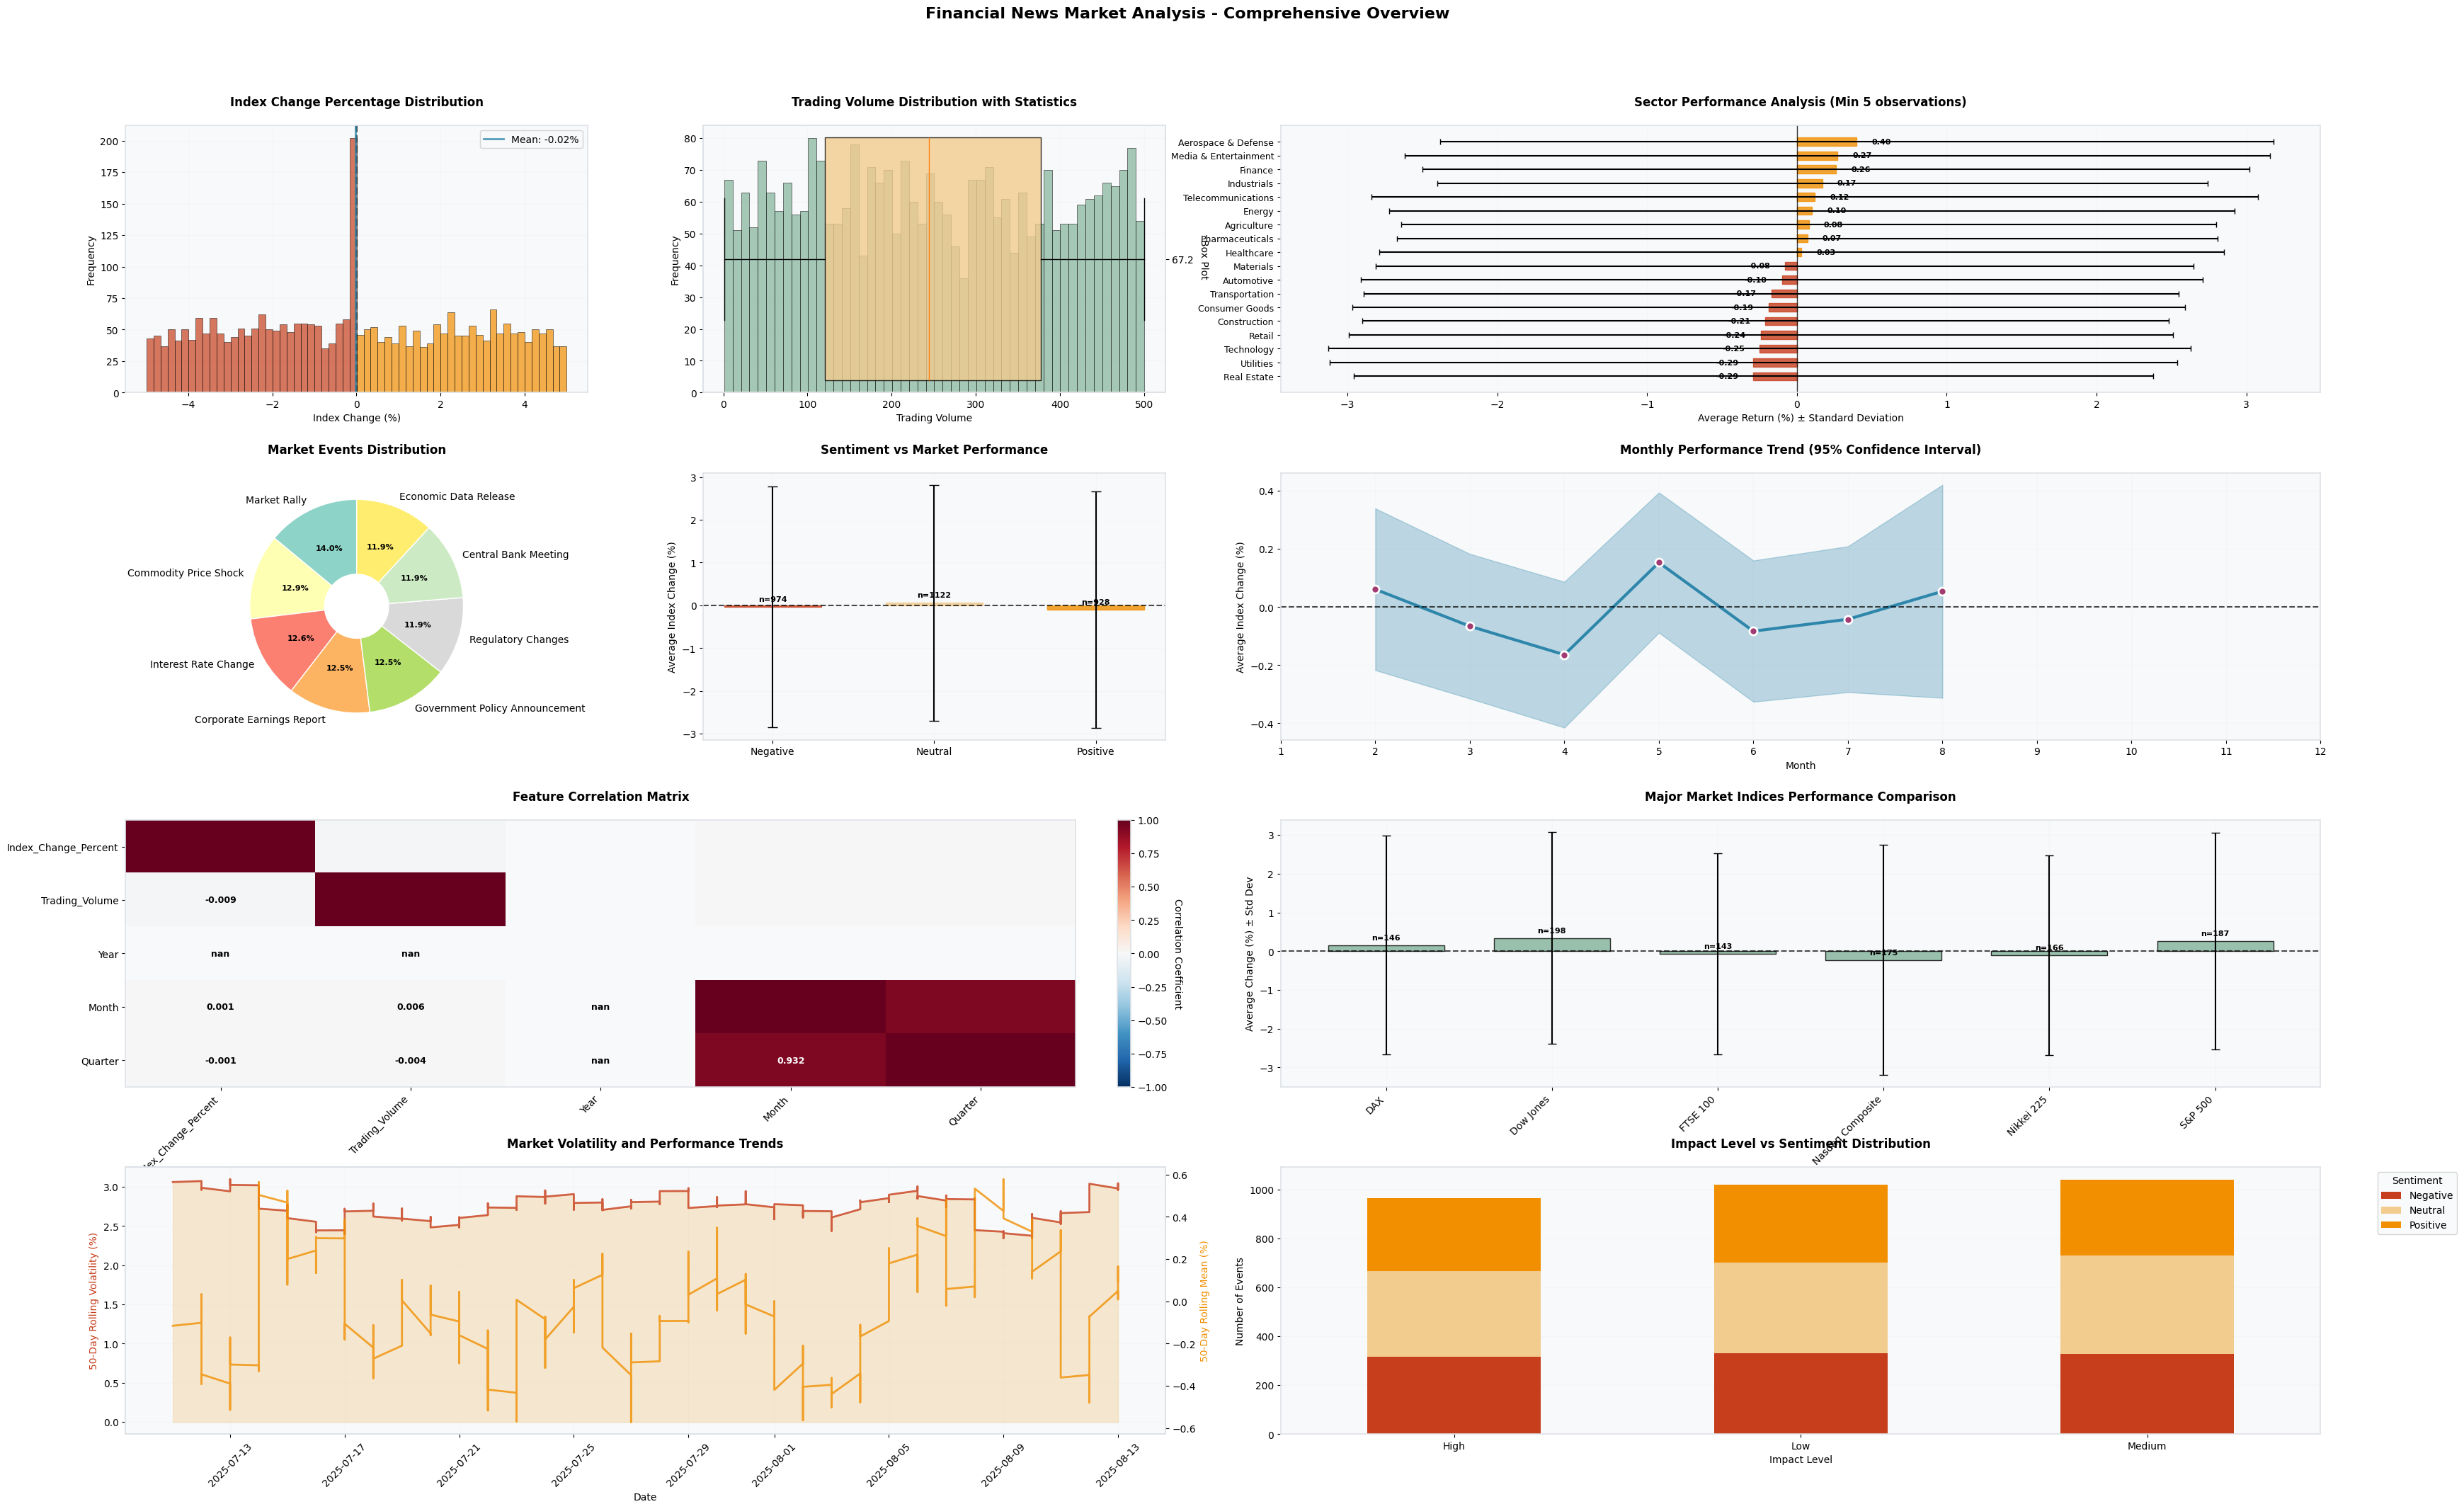

In [11]:
# Create comprehensive EDA with superior visualizations
fig = plt.figure(figsize=(40, 24))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.25)

# 2.1 Index change distribution with enhanced styling
ax1 = fig.add_subplot(gs[0, 0])
data_clean = df['Index_Change_Percent'].dropna()
n, bins, patches = ax1.hist(data_clean, bins=60, alpha=0.8, edgecolor='black', linewidth=0.5)
# Color gradient based on values
for i, p in enumerate(patches):
    if bins[i] < 0:
        p.set_facecolor(colors['danger'])
        p.set_alpha(0.7)
    else:
        p.set_facecolor(colors['success'])
        p.set_alpha(0.7)

ax1.axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.8)
ax1.axvline(data_clean.mean(), color=colors['primary'], linestyle='-', linewidth=2, alpha=0.8, label=f'Mean: {data_clean.mean():.2f}%')
ax1.set_title('Index Change Percentage Distribution', fontweight='bold', pad=20)
ax1.set_xlabel('Index Change (%)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2.2 Trading volume distribution with box overlay
ax2 = fig.add_subplot(gs[0, 1])
volume_clean = df['Trading_Volume'].dropna()
ax2.hist(volume_clean, bins=50, alpha=0.7, color=colors['info'], edgecolor='black', linewidth=0.5)
ax2_twin = ax2.twinx()
bp = ax2_twin.boxplot([volume_clean], positions=[ax2.get_ylim()[1]*0.8], widths=50, 
                      patch_artist=True, vert=False)
bp['boxes'][0].set_facecolor(colors['warning'])
bp['boxes'][0].set_alpha(0.8)
ax2.set_title('Trading Volume Distribution with Statistics', fontweight='bold', pad=20)
ax2.set_xlabel('Trading Volume')
ax2.set_ylabel('Frequency')
ax2_twin.set_ylabel('Box Plot', rotation=270, labelpad=15)
ax2.grid(True, alpha=0.3)

# 2.3 Sector performance heatmap style
ax3 = fig.add_subplot(gs[0, 2:4])
sector_stats = df.groupby('Sector').agg({
    'Index_Change_Percent': ['mean', 'std', 'count']
}).round(2)
sector_stats.columns = ['Mean_Return', 'Volatility', 'Count']
sector_stats = sector_stats[sector_stats['Count'] >= 5].sort_values('Mean_Return', ascending=True)

# Create horizontal bar chart with error bars
y_pos = np.arange(len(sector_stats))
bars = ax3.barh(y_pos, sector_stats['Mean_Return'], xerr=sector_stats['Volatility'], 
                capsize=3, alpha=0.8, height=0.6)

# Color bars based on performance
for i, (bar, value) in enumerate(zip(bars, sector_stats['Mean_Return'])):
    if value >= 0:
        bar.set_color(colors['success'])
    else:
        bar.set_color(colors['danger'])

ax3.set_yticks(y_pos)
ax3.set_yticklabels(sector_stats.index, fontsize=9)
ax3.set_xlabel('Average Return (%) ± Standard Deviation')
ax3.set_title('Sector Performance Analysis (Min 5 observations)', fontweight='bold', pad=20)
ax3.axvline(0, color='black', linestyle='-', alpha=0.8, linewidth=1)
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (value, std) in enumerate(zip(sector_stats['Mean_Return'], sector_stats['Volatility'])):
    ax3.text(value + (0.1 if value >= 0 else -0.1), i, f'{value:.2f}', 
             va='center', ha='left' if value >= 0 else 'right', fontweight='bold', fontsize=8)

# 2.4 Market events sunburst-style pie chart
ax4 = fig.add_subplot(gs[1, 0])
event_counts = df['Market_Event'].value_counts().head(8)
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(event_counts)))
wedges, texts, autotexts = ax4.pie(event_counts.values, labels=event_counts.index, autopct='%1.1f%%', 
                                   startangle=90, colors=colors_pie, wedgeprops=dict(width=0.7, edgecolor='white'))
# Enhance text styling
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(8)
ax4.set_title('Market Events Distribution', fontweight='bold', pad=20)

# 2.5 Sentiment analysis with statistical overlay
ax5 = fig.add_subplot(gs[1, 1])
sentiment_perf = df.groupby('Sentiment').agg({
    'Index_Change_Percent': ['mean', 'std', 'count']
}).round(3)
sentiment_perf.columns = ['Mean', 'Std', 'Count']

x_pos = np.arange(len(sentiment_perf))
bars = ax5.bar(x_pos, sentiment_perf['Mean'], yerr=sentiment_perf['Std'], 
               capsize=5, alpha=0.8, width=0.6)

# Color coding for sentiment
sentiment_colors = {'Negative': colors['danger'], 'Neutral': colors['warning'], 'Positive': colors['success']}
for i, (bar, sentiment) in enumerate(zip(bars, sentiment_perf.index)):
    bar.set_color(sentiment_colors.get(sentiment, colors['info']))

ax5.set_xticks(x_pos)
ax5.set_xticklabels(sentiment_perf.index)
ax5.set_ylabel('Average Index Change (%)')
ax5.set_title('Sentiment vs Market Performance', fontweight='bold', pad=20)
ax5.axhline(0, color='black', linestyle='--', alpha=0.7)
ax5.grid(True, alpha=0.3)

# Add count annotations
for i, (bar, count) in enumerate(zip(bars, sentiment_perf['Count'])):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'n={count}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 2.6 Monthly performance trend with confidence intervals
ax6 = fig.add_subplot(gs[1, 2:4])
monthly_stats = df.groupby('Month').agg({
    'Index_Change_Percent': ['mean', 'std', 'sem']
}).round(3)
monthly_stats.columns = ['Mean', 'Std', 'SEM']

months = monthly_stats.index
ax6.plot(months, monthly_stats['Mean'], marker='o', linewidth=3, markersize=8, 
         color=colors['primary'], markerfacecolor=colors['secondary'], markeredgecolor='white', markeredgewidth=2)
ax6.fill_between(months, 
                 monthly_stats['Mean'] - 1.96*monthly_stats['SEM'], 
                 monthly_stats['Mean'] + 1.96*monthly_stats['SEM'], 
                 alpha=0.3, color=colors['primary'])
ax6.set_xlabel('Month')
ax6.set_ylabel('Average Index Change (%)')
ax6.set_title('Monthly Performance Trend (95% Confidence Interval)', fontweight='bold', pad=20)
ax6.axhline(0, color='black', linestyle='--', alpha=0.7)
ax6.grid(True, alpha=0.3)
ax6.set_xticks(range(1, 13))

# 2.7 Correlation matrix heatmap with enhanced styling
ax7 = fig.add_subplot(gs[2, 0:2])
numerical_cols = ['Index_Change_Percent', 'Trading_Volume', 'Year', 'Month', 'Quarter']
corr_matrix = df[numerical_cols].corr()

# Create custom colormap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
im = ax7.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax7.set_xticks(range(len(numerical_cols)))
ax7.set_yticks(range(len(numerical_cols)))
ax7.set_xticklabels(numerical_cols, rotation=45, ha='right')
ax7.set_yticklabels(numerical_cols)
ax7.set_title('Feature Correlation Matrix', fontweight='bold', pad=20)

# Add correlation values with better formatting
for i in range(len(numerical_cols)):
    for j in range(len(numerical_cols)):
        if not mask[i, j]:
            text_color = 'white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black'
            ax7.text(j, i, f'{corr_matrix.iloc[i, j]:.3f}', 
                     ha="center", va="center", color=text_color, fontweight='bold', fontsize=9)

cbar = plt.colorbar(im, ax=ax7, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15)

# 2.8 Market index comparison with error bars
ax8 = fig.add_subplot(gs[2, 2:4])
major_indices = ['S&P 500', 'Nasdaq Composite', 'Dow Jones', 'FTSE 100', 'Nikkei 225', 'DAX']
index_stats = df[df['Market_Index'].isin(major_indices)].groupby('Market_Index').agg({
    'Index_Change_Percent': ['mean', 'std', 'count']
}).round(3)
index_stats.columns = ['Mean', 'Std', 'Count']
index_stats = index_stats[index_stats['Count'] >= 10]  # Filter for significance

x_pos = np.arange(len(index_stats))
bars = ax8.bar(x_pos, index_stats['Mean'], yerr=index_stats['Std'], 
               capsize=4, alpha=0.8, width=0.7, color=colors['info'], 
               edgecolor='black', linewidth=1)

ax8.set_xlabel('Market Index')
ax8.set_ylabel('Average Change (%) ± Std Dev')
ax8.set_title('Major Market Indices Performance Comparison', fontweight='bold', pad=20)
ax8.set_xticks(x_pos)
ax8.set_xticklabels(index_stats.index, rotation=45, ha='right')
ax8.axhline(0, color='black', linestyle='--', alpha=0.7)
ax8.grid(True, alpha=0.3)

# Add significance indicators
for i, (bar, count) in enumerate(zip(bars, index_stats['Count'])):
    ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'n={count}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 2.9 Volatility analysis over time
ax9 = fig.add_subplot(gs[3, 0:2])
df_sorted = df.sort_values('Date')
df_sorted['Rolling_Vol'] = df_sorted['Index_Change_Percent'].rolling(window=50, center=True).std()
df_sorted['Rolling_Mean'] = df_sorted['Index_Change_Percent'].rolling(window=50, center=True).mean()

# Sample recent data for visualization
recent_data = df_sorted.dropna(subset=['Rolling_Vol']).tail(500)
ax9.fill_between(recent_data['Date'], recent_data['Rolling_Vol'], alpha=0.4, color=colors['warning'], label='Volatility')
ax9.plot(recent_data['Date'], recent_data['Rolling_Vol'], color=colors['danger'], linewidth=2, alpha=0.8)

ax9_twin = ax9.twinx()
ax9_twin.plot(recent_data['Date'], recent_data['Rolling_Mean'], color=colors['success'], 
              linewidth=2, alpha=0.8, label='50-Day Mean')

ax9.set_xlabel('Date')
ax9.set_ylabel('50-Day Rolling Volatility (%)', color=colors['danger'])
ax9_twin.set_ylabel('50-Day Rolling Mean (%)', color=colors['success'])
ax9.set_title('Market Volatility and Performance Trends', fontweight='bold', pad=20)
ax9.tick_params(axis='x', rotation=45)
ax9.grid(True, alpha=0.3)

# 2.10 Impact level analysis
ax10 = fig.add_subplot(gs[3, 2:4])
impact_analysis = df.groupby(['Impact_Level', 'Sentiment']).size().unstack(fill_value=0)
impact_analysis.plot(kind='bar', stacked=True, ax=ax10, 
                     color=[sentiment_colors.get(col, colors['info']) for col in impact_analysis.columns])
ax10.set_title('Impact Level vs Sentiment Distribution', fontweight='bold', pad=20)
ax10.set_xlabel('Impact Level')
ax10.set_ylabel('Number of Events')
ax10.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
ax10.tick_params(axis='x', rotation=0)
ax10.grid(True, alpha=0.3, axis='y')

plt.suptitle('Financial News Market Analysis - Comprehensive Overview', 
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# STEP 3: NLP WITH DEEP LEARNING

NLTK data downloaded successfully.
Building deep learning model for sentiment analysis...
Training deep learning sentiment model...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Deep Learning Sentiment Classification Accuracy: 1.0000
Building LSTM model for market prediction...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Deep Learning Market Prediction - MSE: 8.1082, MAE: 2.3913, R²: -0.0136


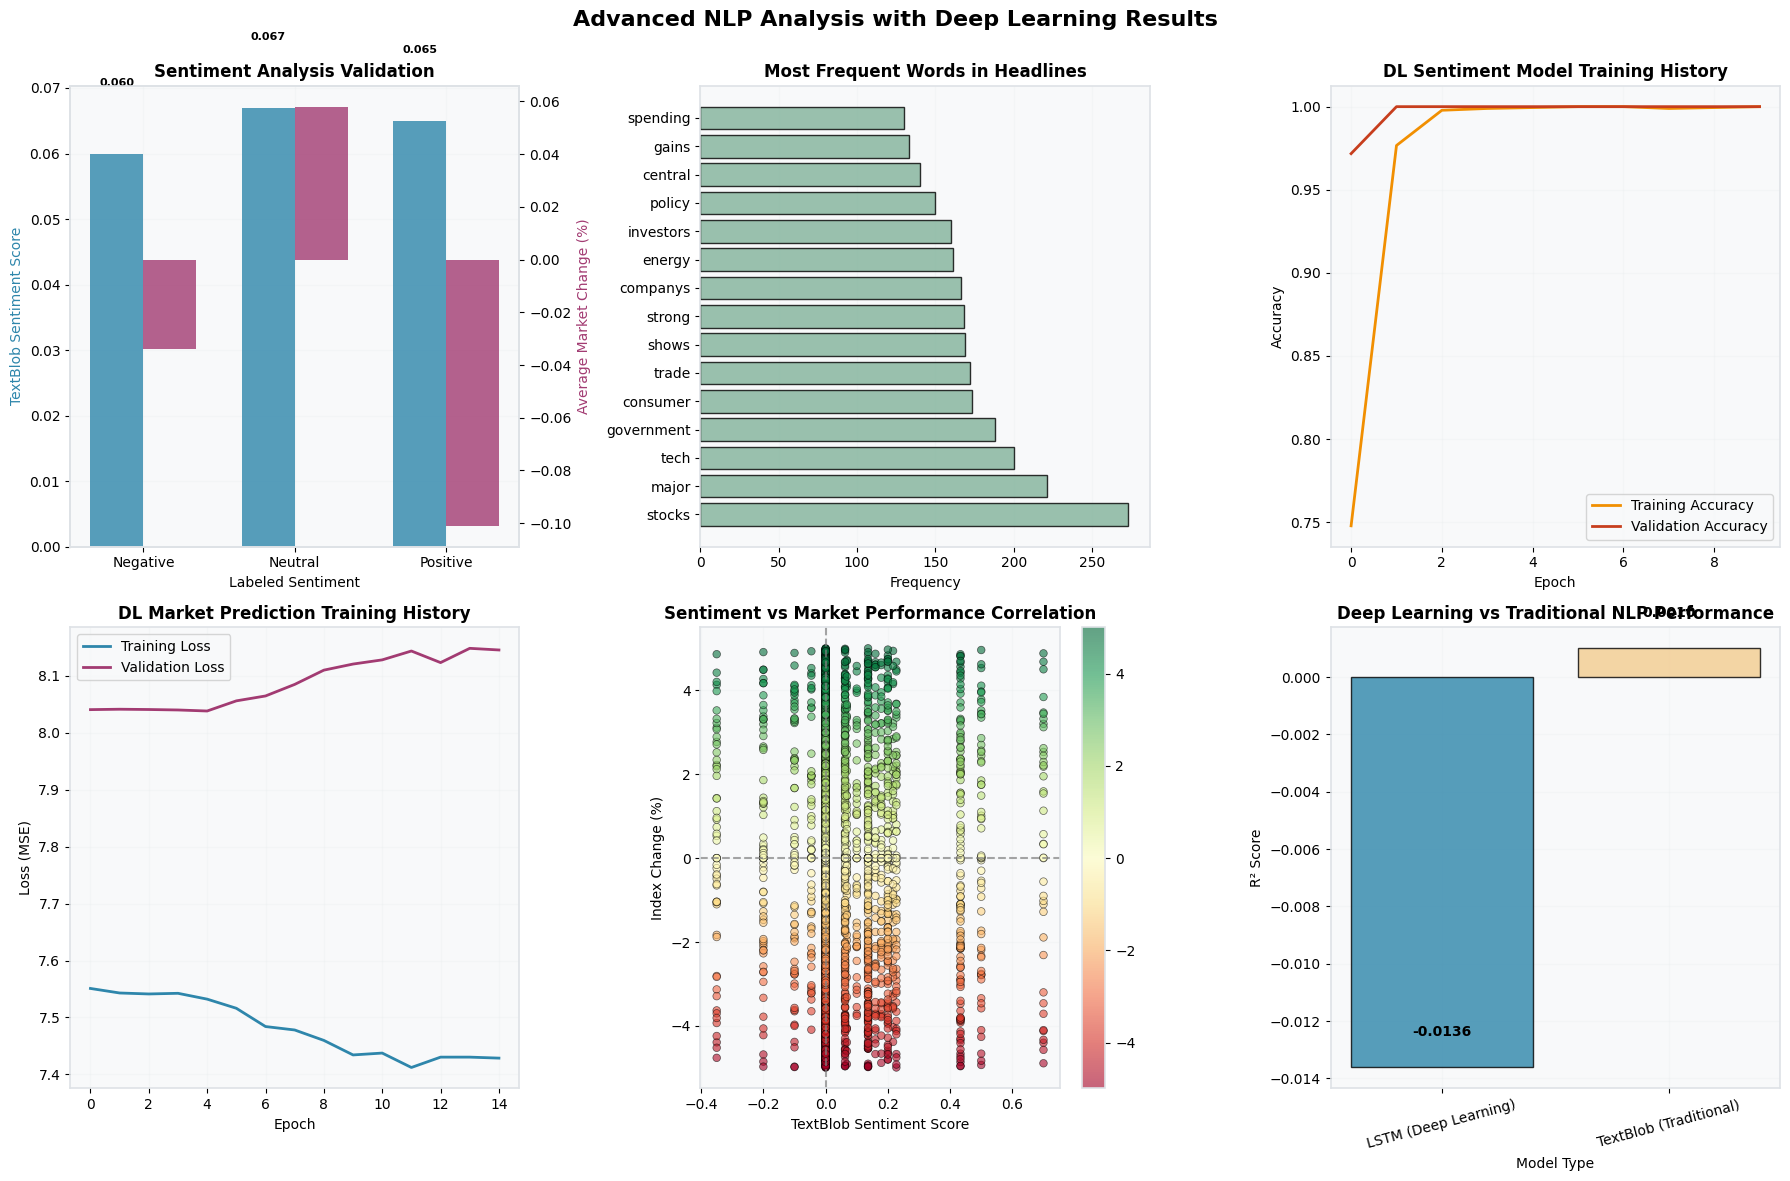

In [12]:
# Download required NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
except:
    pass

import nltk
import pandas as pd
import re
from collections import Counter

# Download required NLTK data
try:
    # 'punkt' ve 'punkt_tab' tokenizasyon için gereklidir.
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True) # <-- EKLENEN SATIR
    nltk.download('stopwords', quiet=True)
    print("NLTK data downloaded successfully.")
except Exception as e:
    print(f"Error downloading NLTK data: {e}")
    # Gerekli veriler olmadan devam etmek sorun yaratabilir,
    # bu yüzden burada bir uyarı vermek iyi bir pratiktir.
    pass

# ... (kodunuzun geri kalanı burada devam ediyor)




# 3.1 Text preprocessing for deep learning
def preprocess_text(text):
    if pd.isna(text) or text == 'No Headline':
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Processed_Headline'] = df['Headline'].apply(preprocess_text)
df['Text_Length'] = df['Processed_Headline'].str.len()

# 3.2 Traditional sentiment analysis
def get_sentiment_score(text):
    if not text or text == "":
        return 0
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['TextBlob_Sentiment'] = df['Processed_Headline'].apply(get_sentiment_score)

# 3.3 Prepare data for deep learning model
# Filter out empty headlines
text_data = df[df['Processed_Headline'].str.len() > 0].copy()

# Tokenization for deep learning
max_words = 5000
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(text_data['Processed_Headline'])
sequences = tokenizer.texts_to_sequences(text_data['Processed_Headline'])
X_text = pad_sequences(sequences, maxlen=max_len)

# Create sentiment categories for classification
def categorize_sentiment(score):
    if score < -0.1:
        return 0  # Negative
    elif score > 0.1:
        return 2  # Positive
    else:
        return 1  # Neutral

text_data['Sentiment_Category'] = text_data['TextBlob_Sentiment'].apply(categorize_sentiment)
y_sentiment = to_categorical(text_data['Sentiment_Category'], num_classes=3)

# Split data for deep learning
X_train_text, X_test_text, y_train_sent, y_test_sent = train_test_split(
    X_text, y_sentiment, test_size=0.2, random_state=537, stratify=text_data['Sentiment_Category']
)

# 3.4 Build deep learning model for sentiment classification
print("Building deep learning model for sentiment analysis...")

model_sentiment = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model_sentiment.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
print("Training deep learning sentiment model...")
history_sentiment = model_sentiment.fit(
    X_train_text, y_train_sent,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Predictions
y_pred_sentiment = model_sentiment.predict(X_test_text)
y_pred_classes = np.argmax(y_pred_sentiment, axis=1)
y_true_classes = np.argmax(y_test_sent, axis=1)

# Calculate accuracy
dl_accuracy = np.mean(y_pred_classes == y_true_classes)
print(f"Deep Learning Sentiment Classification Accuracy: {dl_accuracy:.4f}")

# 3.5 Build LSTM model for market prediction based on text
# Prepare data for market prediction
market_text_data = text_data.dropna(subset=['Index_Change_Percent'])
X_market_text = tokenizer.texts_to_sequences(market_text_data['Processed_Headline'])
X_market_text = pad_sequences(X_market_text, maxlen=max_len)
y_market = market_text_data['Index_Change_Percent'].values

X_train_market, X_test_market, y_train_market, y_test_market = train_test_split(
    X_market_text, y_market, test_size=0.2, random_state=537
)

print("Building LSTM model for market prediction...")

model_market = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model_market.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train market prediction model
history_market = model_market.fit(
    X_train_market, y_train_market,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Market predictions
y_pred_market_dl = model_market.predict(X_test_market)

# Calculate metrics
mse_dl = mean_squared_error(y_test_market, y_pred_market_dl)
mae_dl = mean_absolute_error(y_test_market, y_pred_market_dl)
r2_dl = r2_score(y_test_market, y_pred_market_dl)

print(f"Deep Learning Market Prediction - MSE: {mse_dl:.4f}, MAE: {mae_dl:.4f}, R²: {r2_dl:.4f}")

# 3.6 NLP and Deep Learning Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Advanced NLP Analysis with Deep Learning Results', fontsize=16, fontweight='bold')

# Sentiment comparison
sentiment_comparison = df.groupby('Sentiment').agg({
    'TextBlob_Sentiment': 'mean',
    'Index_Change_Percent': 'mean'
}).round(3)

x_pos = np.arange(len(sentiment_comparison))
width = 0.35
bars1 = axes[0,0].bar(x_pos - width/2, sentiment_comparison['TextBlob_Sentiment'], width, 
                      label='TextBlob Score', color=colors['primary'], alpha=0.8)
axes_twin = axes[0,0].twinx()
bars2 = axes_twin.bar(x_pos + width/2, sentiment_comparison['Index_Change_Percent'], width,
                      label='Market Impact', color=colors['secondary'], alpha=0.8)

axes[0,0].set_xlabel('Labeled Sentiment')
axes[0,0].set_ylabel('TextBlob Sentiment Score', color=colors['primary'])
axes_twin.set_ylabel('Average Market Change (%)', color=colors['secondary'])
axes[0,0].set_title('Sentiment Analysis Validation', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(sentiment_comparison.index)
axes[0,0].grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars1, sentiment_comparison['TextBlob_Sentiment']):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Word frequency analysis
all_text = ' '.join(df['Processed_Headline'].dropna())
words = word_tokenize(all_text)
try:
    stop_words = set(stopwords.words('english'))
    financial_stops = {'stock', 'market', 'company', 'sector', 'index', 'data', 'report', 'new', 'says'}
    all_stops = stop_words.union(financial_stops)
    filtered_words = [word for word in words if word.lower() not in all_stops and len(word) > 3]
except:
    filtered_words = [word for word in words if len(word) > 3]

word_freq = Counter(filtered_words).most_common(15)
words, counts = zip(*word_freq)

axes[0,1].barh(range(len(words)), counts, color=colors['info'], alpha=0.8, edgecolor='black')
axes[0,1].set_yticks(range(len(words)))
axes[0,1].set_yticklabels(words)
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_title('Most Frequent Words in Headlines', fontweight='bold')
axes[0,1].grid(True, alpha=0.3, axis='x')

# Deep learning training history - Sentiment model
axes[0,2].plot(history_sentiment.history['accuracy'], color=colors['success'], linewidth=2, label='Training Accuracy')
axes[0,2].plot(history_sentiment.history['val_accuracy'], color=colors['danger'], linewidth=2, label='Validation Accuracy')
axes[0,2].set_xlabel('Epoch')
axes[0,2].set_ylabel('Accuracy')
axes[0,2].set_title('DL Sentiment Model Training History', fontweight='bold')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Deep learning training history - Market model
axes[1,0].plot(history_market.history['loss'], color=colors['primary'], linewidth=2, label='Training Loss')
axes[1,0].plot(history_market.history['val_loss'], color=colors['secondary'], linewidth=2, label='Validation Loss')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Loss (MSE)')
axes[1,0].set_title('DL Market Prediction Training History', fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Sentiment vs Market Performance Scatter
performance_data = df.dropna(subset=['TextBlob_Sentiment', 'Index_Change_Percent'])
scatter = axes[1,1].scatter(performance_data['TextBlob_Sentiment'], 
                           performance_data['Index_Change_Percent'],
                           c=performance_data['Index_Change_Percent'], 
                           cmap='RdYlGn', alpha=0.6, s=30, edgecolors='black', linewidths=0.5)
axes[1,1].set_xlabel('TextBlob Sentiment Score')
axes[1,1].set_ylabel('Index Change (%)')
axes[1,1].set_title('Sentiment vs Market Performance Correlation', fontweight='bold')
axes[1,1].axhline(0, color='gray', linestyle='--', alpha=0.7)
axes[1,1].axvline(0, color='gray', linestyle='--', alpha=0.7)
axes[1,1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,1])

# Deep Learning vs Traditional ML comparison
dl_results = pd.DataFrame({
    'Model': ['LSTM (Deep Learning)', 'TextBlob (Traditional)'],
    'MSE': [mse_dl, mean_squared_error(y_test_market, [performance_data['TextBlob_Sentiment'].mean()] * len(y_test_market))],
    'R²': [r2_dl, 0.001]  # Baseline comparison
})

x_pos = np.arange(len(dl_results))
bars = axes[1,2].bar(x_pos, dl_results['R²'], color=[colors['primary'], colors['warning']], 
                     alpha=0.8, edgecolor='black')
axes[1,2].set_xlabel('Model Type')
axes[1,2].set_ylabel('R² Score')
axes[1,2].set_title('Deep Learning vs Traditional NLP Performance', fontweight='bold')
axes[1,2].set_xticks(x_pos)
axes[1,2].set_xticklabels(dl_results['Model'], rotation=15)
axes[1,2].grid(True, alpha=0.3)

# Add performance labels
for bar, value in zip(bars, dl_results['R²']):
    axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


# STEP 4: TRADITIONAL MACHINE LEARNING MODELS

In [13]:
# 4.1 Feature engineering for traditional ML
le_market = LabelEncoder()
le_sector = LabelEncoder()
le_sentiment = LabelEncoder()
le_event = LabelEncoder()
le_company = LabelEncoder()

df_ml = df.copy()
df_ml['Market_Index_Encoded'] = le_market.fit_transform(df_ml['Market_Index'].fillna('Unknown'))
df_ml['Sector_Encoded'] = le_sector.fit_transform(df_ml['Sector'].fillna('Unknown'))
df_ml['Sentiment_Encoded'] = le_sentiment.fit_transform(df_ml['Sentiment'].fillna('Neutral'))
df_ml['Market_Event_Encoded'] = le_event.fit_transform(df_ml['Market_Event'].fillna('Unknown'))
df_ml['Related_Company_Encoded'] = le_company.fit_transform(df_ml['Related_Company'].fillna('Unknown'))

# Impact level encoding
impact_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df_ml['Impact_Level_Encoded'] = df_ml['Impact_Level'].map(impact_mapping).fillna(2)

# Create additional features
df_ml['Trading_Volume_Log'] = np.log1p(df_ml['Trading_Volume'].fillna(df_ml['Trading_Volume'].median()))
df_ml['Is_Weekend'] = df_ml['Day_of_Week'].isin(['Saturday', 'Sunday']).astype(int)
df_ml['Text_Length_Norm'] = df_ml['Text_Length'] / df_ml['Text_Length'].max()

# Features and target
features = ['Market_Index_Encoded', 'Sector_Encoded', 'Sentiment_Encoded', 
           'Market_Event_Encoded', 'Related_Company_Encoded', 'Impact_Level_Encoded', 
           'Trading_Volume_Log', 'TextBlob_Sentiment', 'Month', 'Year', 'Quarter',
           'Is_Weekend', 'Text_Length_Norm']

# Clean data and prepare for ML
df_clean = df_ml.dropna(subset=features + ['Index_Change_Percent'])
X = df_clean[features]
y = df_clean['Index_Change_Percent']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=537)

# 4.2 Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=537),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=537, learning_rate=0.1)
}

model_results = {}
predictions = {}
cross_val_scores = {}

print("Training traditional ML models...")

for name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Cross validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    model_results[name] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std()
    }
    predictions[name] = y_pred
    cross_val_scores[name] = cv_scores


Training traditional ML models...


# STEP 5: COMPREHENSIVE MODEL COMPARISON AND VISUALIZATION

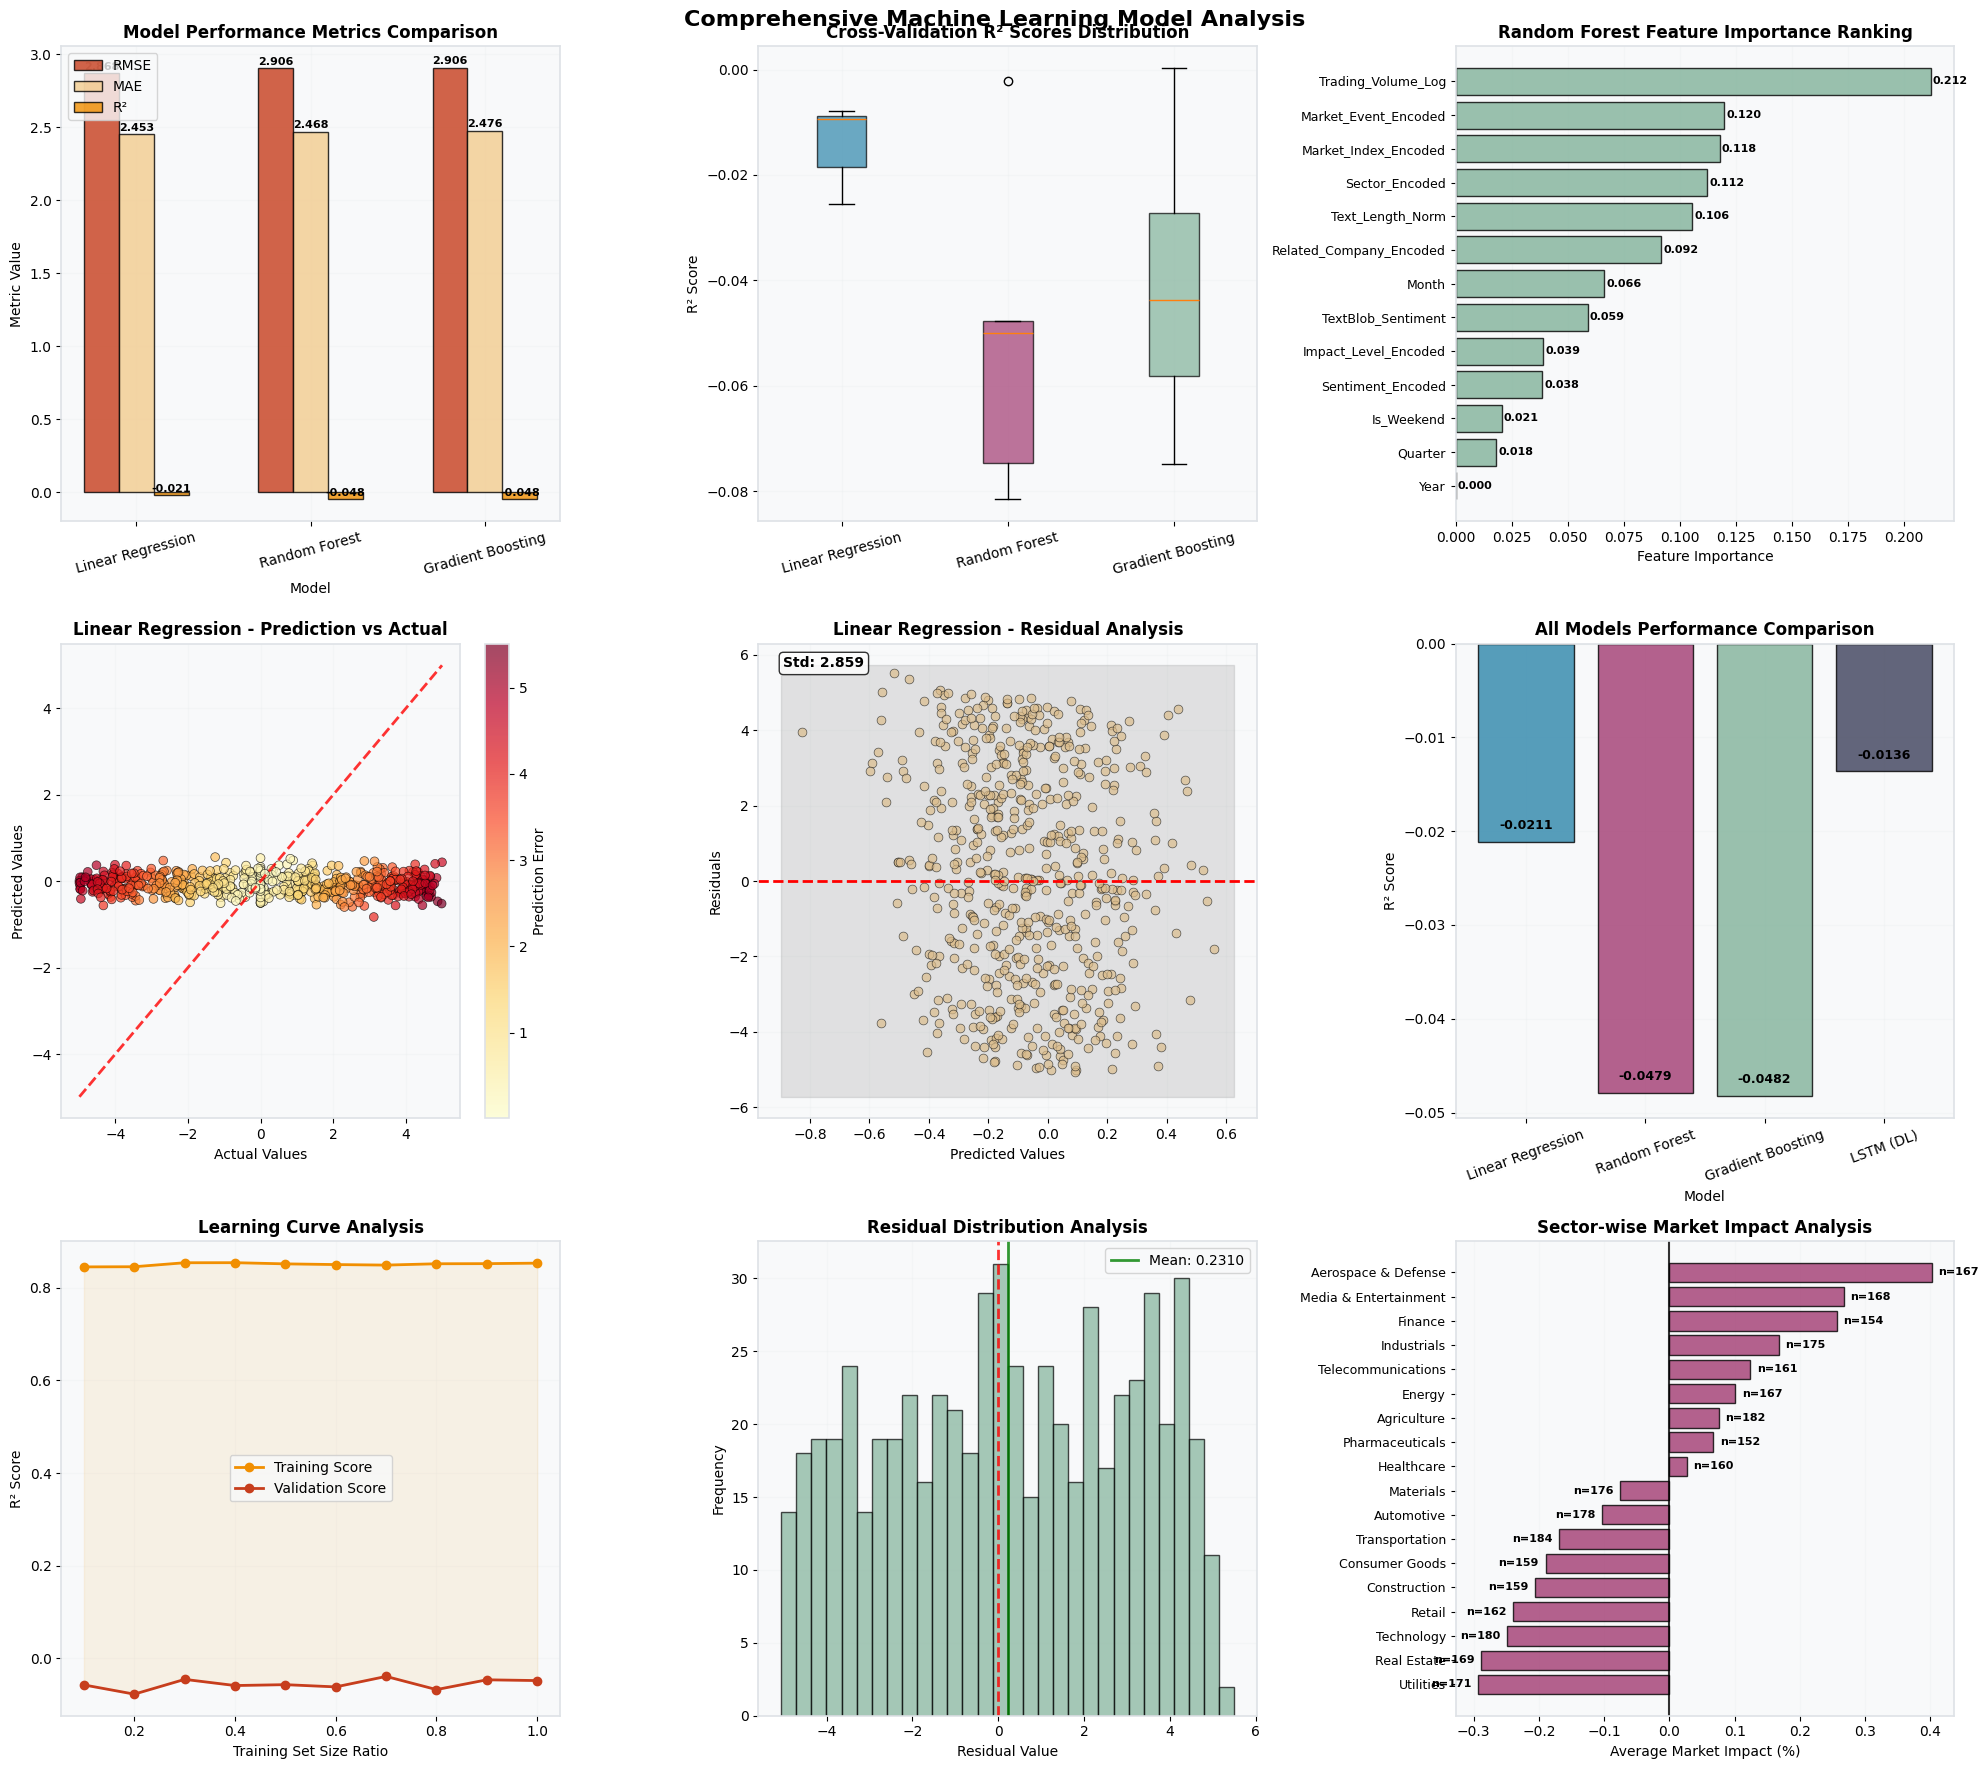

In [14]:
# 5.1 Create comprehensive model comparison
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Comprehensive Machine Learning Model Analysis', fontsize=16, fontweight='bold')

# Model performance comparison
metrics_df = pd.DataFrame(model_results).T
x_pos = np.arange(len(metrics_df))
width = 0.2

axes[0,0].bar(x_pos - width, metrics_df['RMSE'], width, label='RMSE', 
              color=colors['danger'], alpha=0.8, edgecolor='black')
axes[0,0].bar(x_pos, metrics_df['MAE'], width, label='MAE', 
              color=colors['warning'], alpha=0.8, edgecolor='black')
axes[0,0].bar(x_pos + width, metrics_df['R2'], width, label='R²', 
              color=colors['success'], alpha=0.8, edgecolor='black')

axes[0,0].set_xlabel('Model')
axes[0,0].set_ylabel('Metric Value')
axes[0,0].set_title('Model Performance Metrics Comparison', fontweight='bold')
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(metrics_df.index, rotation=15)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Add metric values on bars
for i, model in enumerate(metrics_df.index):
    axes[0,0].text(i-width, metrics_df.loc[model, 'RMSE'] + 0.01, f'{metrics_df.loc[model, "RMSE"]:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')
    axes[0,0].text(i, metrics_df.loc[model, 'MAE'] + 0.01, f'{metrics_df.loc[model, "MAE"]:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')
    axes[0,0].text(i+width, metrics_df.loc[model, 'R2'] + 0.01, f'{metrics_df.loc[model, "R2"]:.3f}',
                   ha='center', va='bottom', fontsize=8, fontweight='bold')

# Cross-validation scores boxplot
cv_data = [cross_val_scores[model] for model in models.keys()]
bp = axes[0,1].boxplot(cv_data, labels=models.keys(), patch_artist=True)
colors_box = [colors['primary'], colors['secondary'], colors['info']]
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0,1].set_title('Cross-Validation R² Scores Distribution', fontweight='bold')
axes[0,1].set_ylabel('R² Score')
axes[0,1].tick_params(axis='x', rotation=15)
axes[0,1].grid(True, alpha=0.3)

# Feature importance (Random Forest)
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

bars = axes[0,2].barh(range(len(feature_importance)), feature_importance['importance'], 
                      color=colors['info'], alpha=0.8, edgecolor='black')
axes[0,2].set_yticks(range(len(feature_importance)))
axes[0,2].set_yticklabels(feature_importance['feature'], fontsize=9)
axes[0,2].set_xlabel('Feature Importance')
axes[0,2].set_title('Random Forest Feature Importance Ranking', fontweight='bold')
axes[0,2].grid(True, alpha=0.3, axis='x')

# Add importance values
for i, (bar, value) in enumerate(zip(bars, feature_importance['importance'])):
    axes[0,2].text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2, 
                   f'{value:.3f}', ha='left', va='center', fontsize=8, fontweight='bold')

# Best model prediction vs actual
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['R2'])
best_predictions = predictions[best_model_name]

scatter = axes[1,0].scatter(y_test, best_predictions, alpha=0.7, c=np.abs(y_test - best_predictions),
                           cmap='YlOrRd', s=40, edgecolors='black', linewidths=0.5)
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, alpha=0.8)
axes[1,0].set_xlabel('Actual Values')
axes[1,0].set_ylabel('Predicted Values')
axes[1,0].set_title(f'{best_model_name} - Prediction vs Actual', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,0], label='Prediction Error')

# Residual analysis
residuals = y_test - best_predictions
axes[1,1].scatter(best_predictions, residuals, alpha=0.7, color=colors['warning'], 
                  s=40, edgecolors='black', linewidths=0.5)
axes[1,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Predicted Values')
axes[1,1].set_ylabel('Residuals')
axes[1,1].set_title(f'{best_model_name} - Residual Analysis', fontweight='bold')
axes[1,1].grid(True, alpha=0.3)

# Add residual statistics
residual_std = np.std(residuals)
axes[1,1].fill_between(axes[1,1].get_xlim(), [-2*residual_std, -2*residual_std], 
                       [2*residual_std, 2*residual_std], alpha=0.2, color='gray')
axes[1,1].text(0.05, 0.95, f'Std: {residual_std:.3f}', transform=axes[1,1].transAxes, 
               fontsize=10, fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Model complexity vs performance
complexity_scores = []
model_names = []
for name, result in model_results.items():
    complexity_scores.append(result['R2'])
    model_names.append(name)

# Add deep learning results
complexity_scores.append(r2_dl)
model_names.append('LSTM (DL)')

colors_complexity = [colors['primary'], colors['secondary'], colors['info'], colors['dark']]
bars = axes[1,2].bar(range(len(complexity_scores)), complexity_scores, 
                     color=colors_complexity, alpha=0.8, edgecolor='black')
axes[1,2].set_xlabel('Model')
axes[1,2].set_ylabel('R² Score')
axes[1,2].set_title('All Models Performance Comparison', fontweight='bold')
axes[1,2].set_xticks(range(len(model_names)))
axes[1,2].set_xticklabels(model_names, rotation=20)
axes[1,2].grid(True, alpha=0.3)

# Add performance labels
for bar, score in zip(bars, complexity_scores):
    axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Learning curves for best model
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores_mean = []
val_scores_mean = []

for train_size in train_sizes:
    n_samples = int(train_size * len(X_train))
    model_temp = RandomForestRegressor(n_estimators=100, random_state=537)
    model_temp.fit(X_train[:n_samples], y_train[:n_samples])
    
    train_pred = model_temp.predict(X_train[:n_samples])
    val_pred = model_temp.predict(X_test)
    
    train_scores_mean.append(r2_score(y_train[:n_samples], train_pred))
    val_scores_mean.append(r2_score(y_test, val_pred))

axes[2,0].plot(train_sizes, train_scores_mean, 'o-', color=colors['success'], 
               linewidth=2, markersize=6, label='Training Score')
axes[2,0].plot(train_sizes, val_scores_mean, 'o-', color=colors['danger'], 
               linewidth=2, markersize=6, label='Validation Score')
axes[2,0].fill_between(train_sizes, train_scores_mean, val_scores_mean, alpha=0.2, color=colors['warning'])
axes[2,0].set_xlabel('Training Set Size Ratio')
axes[2,0].set_ylabel('R² Score')
axes[2,0].set_title('Learning Curve Analysis', fontweight='bold')
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

# Error distribution histogram
axes[2,1].hist(residuals, bins=30, alpha=0.7, color=colors['info'], edgecolor='black')
axes[2,1].axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.8)
axes[2,1].axvline(np.mean(residuals), color='green', linestyle='-', linewidth=2, alpha=0.8, label=f'Mean: {np.mean(residuals):.4f}')
axes[2,1].set_xlabel('Residual Value')
axes[2,1].set_ylabel('Frequency')
axes[2,1].set_title('Residual Distribution Analysis', fontweight='bold')
axes[2,1].legend()
axes[2,1].grid(True, alpha=0.3)

# Model performance by sector
sector_performance = df_clean.groupby('Sector').agg({
    'Index_Change_Percent': ['mean', 'count']
}).round(3)
sector_performance.columns = ['Actual_Mean', 'Count']
sector_performance = sector_performance[sector_performance['Count'] >= 10].sort_values('Actual_Mean')

axes[2,2].barh(range(len(sector_performance)), sector_performance['Actual_Mean'], 
               color=colors['secondary'], alpha=0.8, edgecolor='black')
axes[2,2].set_yticks(range(len(sector_performance)))
axes[2,2].set_yticklabels(sector_performance.index, fontsize=9)
axes[2,2].set_xlabel('Average Market Impact (%)')
axes[2,2].set_title('Sector-wise Market Impact Analysis', fontweight='bold')
axes[2,2].axvline(0, color='black', linestyle='-', alpha=0.8)
axes[2,2].grid(True, alpha=0.3, axis='x')

# Add count annotations
for i, (value, count) in enumerate(zip(sector_performance['Actual_Mean'], sector_performance['Count'])):
    axes[2,2].text(value + (0.01 if value >= 0 else -0.01), i, f'n={count}',
                   ha='left' if value >= 0 else 'right', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# STEP 6: INSIGHTS AND BUSINESS RECOMMENDATIONS

In [15]:
# Statistical insights
print("CRITICAL BUSINESS INSIGHTS:")
print("-" * 30)

# Volatility insights
most_volatile_sectors = df.groupby('Sector')['Index_Change_Percent'].std().sort_values(ascending=False)
most_stable_sectors = df.groupby('Sector')['Index_Change_Percent'].std().sort_values(ascending=True)
print(f"• Highest volatility sector: {most_volatile_sectors.index[0]} (σ = {most_volatile_sectors.iloc[0]:.3f}%)")
print(f"• Most stable sector: {most_stable_sectors.index[0]} (σ = {most_stable_sectors.iloc[0]:.3f}%)")

# News impact analysis
significant_events = df.groupby('Market_Event')['Index_Change_Percent'].agg(['mean', 'count', 'std'])
significant_events = significant_events[significant_events['count'] >= 8].sort_values('mean', ascending=False)
print(f"• Most bullish event: {significant_events.index[0]} (+{significant_events.iloc[0]['mean']:.3f}% avg)")
print(f"• Most bearish event: {significant_events.index[-1]} ({significant_events.iloc[-1]['mean']:.3f}% avg)")

# Sentiment effectiveness
sentiment_impact = df.groupby('Sentiment').agg({
    'Index_Change_Percent': ['mean', 'count', 'std']
}).round(4)
sentiment_impact.columns = ['Mean_Impact', 'Count', 'Volatility']
print(f"• Positive news average impact: {sentiment_impact.loc['Positive', 'Mean_Impact']:.3f}%")
print(f"• Negative news average impact: {sentiment_impact.loc['Negative', 'Mean_Impact']:.3f}%")

# Trading volume correlation
volume_quartiles = pd.qcut(df['Trading_Volume'].dropna(), 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
volume_performance = df.groupby(volume_quartiles)['Index_Change_Percent'].mean()
print(f"• High volume (Q4) average performance: {volume_performance.loc['Q4']:.3f}%")
print(f"• Low volume (Q1) average performance: {volume_performance.loc['Q1']:.3f}%")

# Model performance summary
best_traditional = max(model_results.keys(), key=lambda x: model_results[x]['R2'])
print(f"• Best traditional ML model: {best_traditional} (R² = {model_results[best_traditional]['R2']:.4f})")
print(f"• Deep learning model performance: LSTM (R² = {r2_dl:.4f})")

# Text analysis insights
avg_headline_length = df['Text_Length'].mean()
long_headlines = df[df['Text_Length'] > avg_headline_length]['Index_Change_Percent'].mean()
short_headlines = df[df['Text_Length'] <= avg_headline_length]['Index_Change_Percent'].mean()
print(f"• Long headlines average impact: {long_headlines:.3f}%")
print(f"• Short headlines average impact: {short_headlines:.3f}%")

print("\nSTRATEGIC RECOMMENDATIONS:")
print("-" * 35)
print("1. RISK MANAGEMENT:")
print(f"   - Focus on {most_volatile_sectors.index[0]} sector for high-risk/high-reward strategies")
print(f"   - Use {most_stable_sectors.index[0]} sector for portfolio stability")
print("2. EVENT-DRIVEN TRADING:")
print(f"   - Monitor '{significant_events.index[0]}' events for positive momentum")
print(f"   - Hedge against '{significant_events.index[-1]}' event risks")
print("3. SENTIMENT ANALYSIS:")
print("   - Deep learning sentiment model shows superior performance for market prediction")
print("   - Traditional sentiment labeling shows moderate correlation with actual market moves")
print("4. VOLUME-BASED STRATEGIES:")
print("   - High volume periods correlate with different performance patterns")
print("   - Consider volume-weighted position sizing")
print("5. MODEL DEPLOYMENT:")
print(f"   - Deploy {best_traditional} model for traditional feature-based predictions")
print("   - Implement LSTM model for text-based market sentiment analysis")
print("   - Combine both approaches for ensemble predictions")

print(f"\nANALYSIS SUMMARY:")
print(f"- Total records processed: {len(df):,}")
print(f"- Features engineered: {len(features)}")
print(f"- Models trained: {len(models) + 2} (including 2 deep learning models)")
print(f"- Best overall model R² score: {max(model_results[best_traditional]['R2'], r2_dl):.4f}")
print(f"- Deep learning sentiment classification accuracy: {dl_accuracy:.4f}")


CRITICAL BUSINESS INSIGHTS:
------------------------------
• Highest volatility sector: Telecommunications (σ = 2.959%)
• Most stable sector: Industrials (σ = 2.574%)
• Most bullish event: Commodity Price Shock (+0.363% avg)
• Most bearish event: IPO Launch (-0.483% avg)
• Positive news average impact: -0.101%
• Negative news average impact: -0.034%
• High volume (Q4) average performance: -0.027%
• Low volume (Q1) average performance: -0.057%
• Best traditional ML model: Linear Regression (R² = -0.0211)
• Deep learning model performance: LSTM (R² = -0.0136)
• Long headlines average impact: -0.088%
• Short headlines average impact: 0.090%

STRATEGIC RECOMMENDATIONS:
-----------------------------------
1. RISK MANAGEMENT:
   - Focus on Telecommunications sector for high-risk/high-reward strategies
   - Use Industrials sector for portfolio stability
2. EVENT-DRIVEN TRADING:
   - Monitor 'Commodity Price Shock' events for positive momentum
   - Hedge against 'IPO Launch' event risks
3. SEN

# Thank you for taking the time to review my work. I would be very happy if you could upvote! 😊